In [1]:
import pandas as pd
import seaborn as snstokenize
import matplotlib.pyplot as plt

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
from nltk.corpus import stopwords            #to filterout useless data
stopword = set(stopwords.words('english'))

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier


from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import tensorflow as tf
import transformers
import re
import string

C:\Users\pinok\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the text data
data = pd.read_csv("labeled_data.csv")
data.replace(to_replace=1, value=0, inplace=True)
data.replace(to_replace=2, value=1, inplace=True)
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,3,0,3,0,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,3,0,3,0,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,1,0,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
data["labels"] = data["class"].map({0: "Hate Speech", 
                                    1: "No Hate and Offensive"})
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      1   
1           0      3            0                   3        0      0   
2           1      3            0                   3        0      0   
3           3      3            0                   1        0      0   
4           4      6            0                   6        0      0   

                                               tweet                 labels  
0  !!! RT @mayasolovely: As a woman you shouldn't...  No Hate and Offensive  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...            Hate Speech  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...            Hate Speech  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...            Hate Speech  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...            Hate Speech  


In [4]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Hate Speech
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Hate Speech
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Hate Speech
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Hate Speech


In [5]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [6]:
#applying pre-processing to text data
data.tweet=data['tweet'].apply(clean)

In [7]:
# def remove_custom_words(text, custom_words):
#     words = text.split()
#     filtered_words = [word for word in words if word.lower() not in custom_words]
#     return ' '.join(filtered_words)

# custom_words_to_remove = ["rt", "amp"]

# data = remove_custom_words(text, custom_words_to_remove)
# print(filtered_text)


In [8]:
# removing duplicate data
tweetData = data.drop_duplicates("tweet")

In [9]:
# to see updated number of columns as duplicates entries are removed
tweetData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24506 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24506 non-null  object
 1   labels  24506 non-null  object
dtypes: object(2)
memory usage: 574.4+ KB


In [10]:
# to see the data after pre-processing
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



In [11]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(word) for word in data]
    return data

In [12]:
# to see the data after pre-processing
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



In [13]:
#lemmatizing the processed data
tweetData.loc[:, 'tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))

In [14]:
# to see the data after pre-processing
print(tweetData["tweet"].iloc[0],"\n")
print(tweetData["tweet"].iloc[1],"\n")
print(tweetData["tweet"].iloc[2],"\n")
print(tweetData["tweet"].iloc[3],"\n")
print(tweetData["tweet"].iloc[4],"\n")

rt mayasolovely woman shouldnt complain cleaning house amp man always take trash 

rt boy dats coldtyga dwn bad cuffin dat hoe place 

rt urkindofbrand dawg rt ever fuck bitch start cry confused shit 

rt cganderson vivabased look like tranny 

rt shenikaroberts shit hear might true might faker bitch told ya 



In [15]:
# to see distribution of labels
tweetData['labels'].value_counts()

labels
Hate Speech              20393
No Hate and Offensive     4113
Name: count, dtype: int64

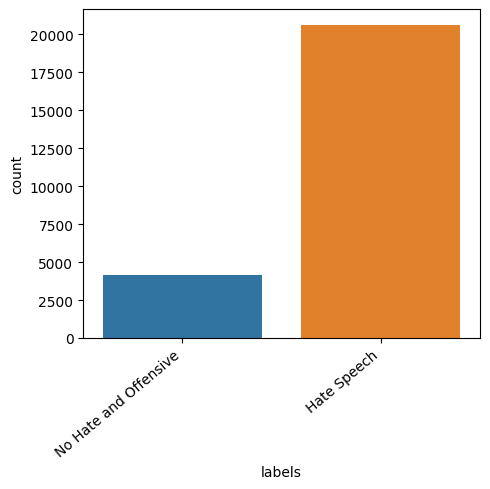

In [16]:
# to visualize the data using a count plot
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='labels', data=data)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

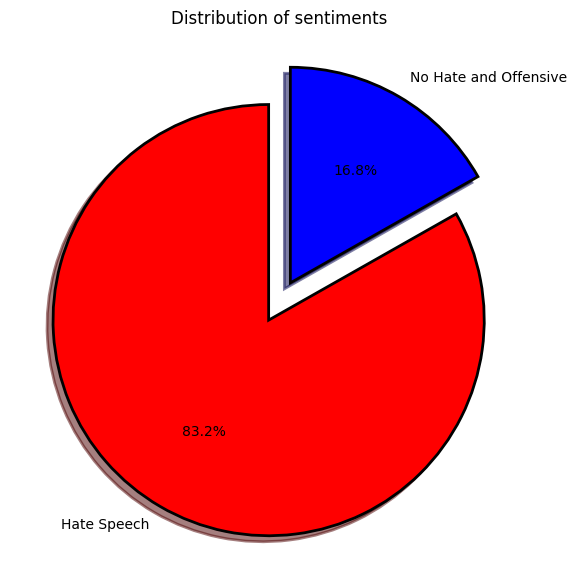

In [17]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = data['labels'].value_counts()
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

#here 0 indicates hate speech, 1 indicates no hate & offensive

In [18]:
# visualizing non-hate tweets
non_hate_tweets = data[data.labels=='No Hate and Offensive']
non_hate_tweets.head()

,tweet,labels
0,rt mayasolovely woman shouldnt complain cleani...,No Hate and Offensive
40,momma said pussy cats inside doghouse,No Hate and Offensive
63,simplyaddictedtoguys woof woof hot scally lad,No Hate and Offensive
66,allaboutmanfeet woof woof hot soles,No Hate and Offensive
67,allyhaaaaa lemmie eat oreo amp dishes one oreo...,No Hate and Offensive


In [19]:
non_hate_tweets.value_counts()

tweet                                                                                                        labels               
best asian massage park slope top rated spa                                                                  No Hate and Offensive    14
grand opening top class oriental massage perfect                                                             No Hate and Offensive     8
best asian massage brooklyn park slope top rated spa                                                         No Hate and Offensive     5
international law enforcement operation disrupts shylock banking malware pcworld international law enforcem  No Hate and Offensive     3
trash                                                                                                        No Hate and Offensive     3
                                                                                                                                      ..
jundishes get wasp spray shoots feet cheaper be

In [20]:
# visualizing non-hate tweets
hate_tweets = data[data.labels=='Hate Speech']
hate_tweets.head()

,tweet,labels
1,rt boy dats coldtyga dwn bad cuffin dat hoe place,Hate Speech
2,rt urkindofbrand dawg rt ever fuck bitch start...,Hate Speech
3,rt cganderson vivabased look like tranny,Hate Speech
4,rt shenikaroberts shit hear might true might f...,Hate Speech
5,tmadisonx shit blows meclaim faithful somebody...,Hate Speech


In [21]:
hate_tweets.value_counts()

tweet                                                                                                         labels     
bitch                                                                                                         Hate Speech    23
pussy                                                                                                         Hate Speech    12
hoe                                                                                                           Hate Speech     9
hoes aint loyal                                                                                               Hate Speech     8
faggot                                                                                                        Hate Speech     8
                                                                                                                             ..
indirect ass little bitches like know fucking number live                                                     

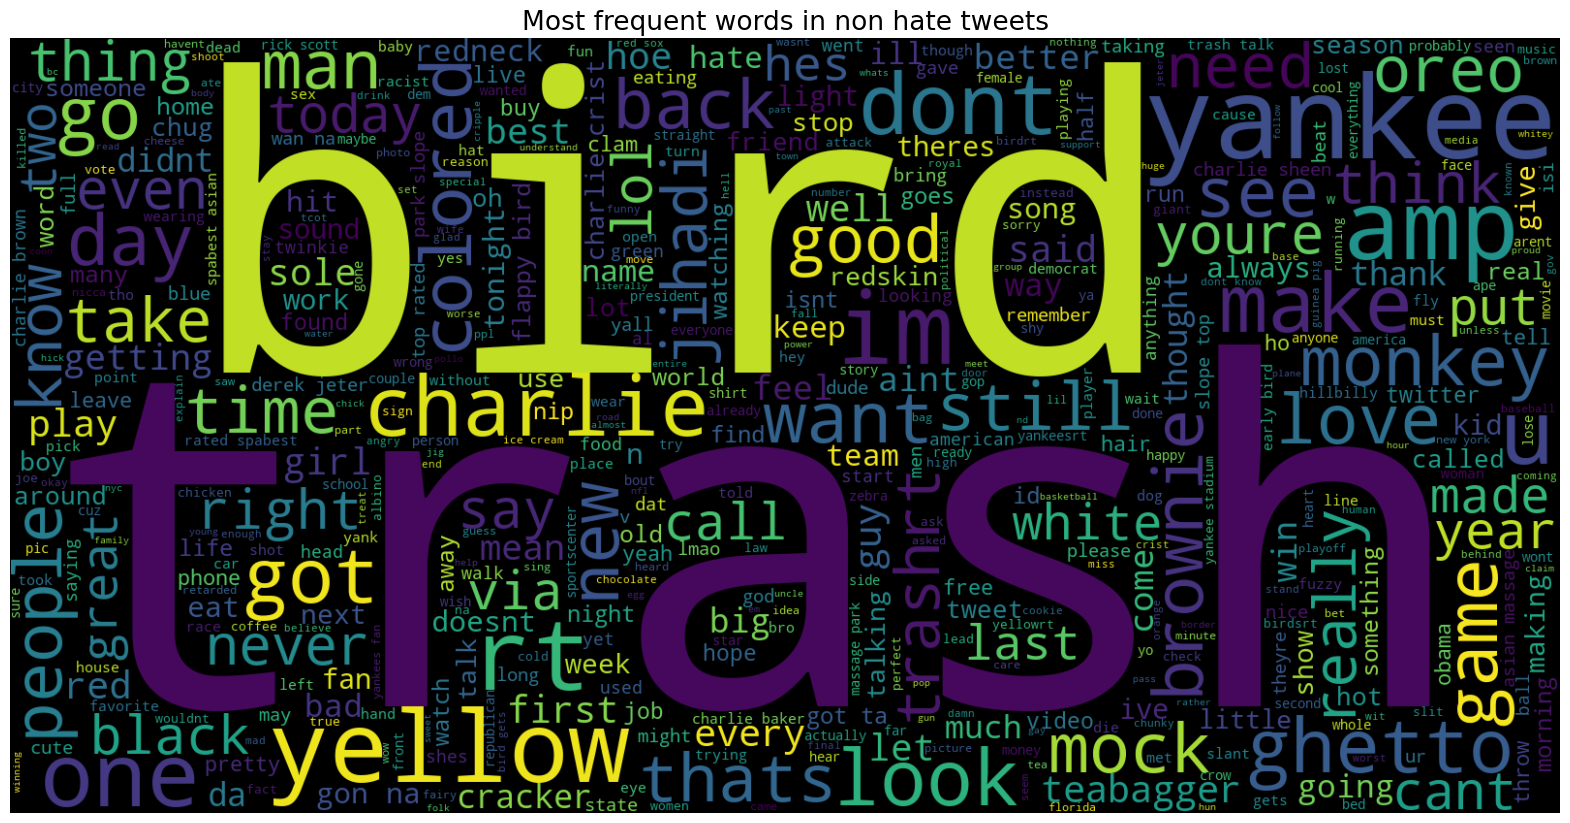

In [22]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in non hate tweets", fontsize=19)
plt.show()

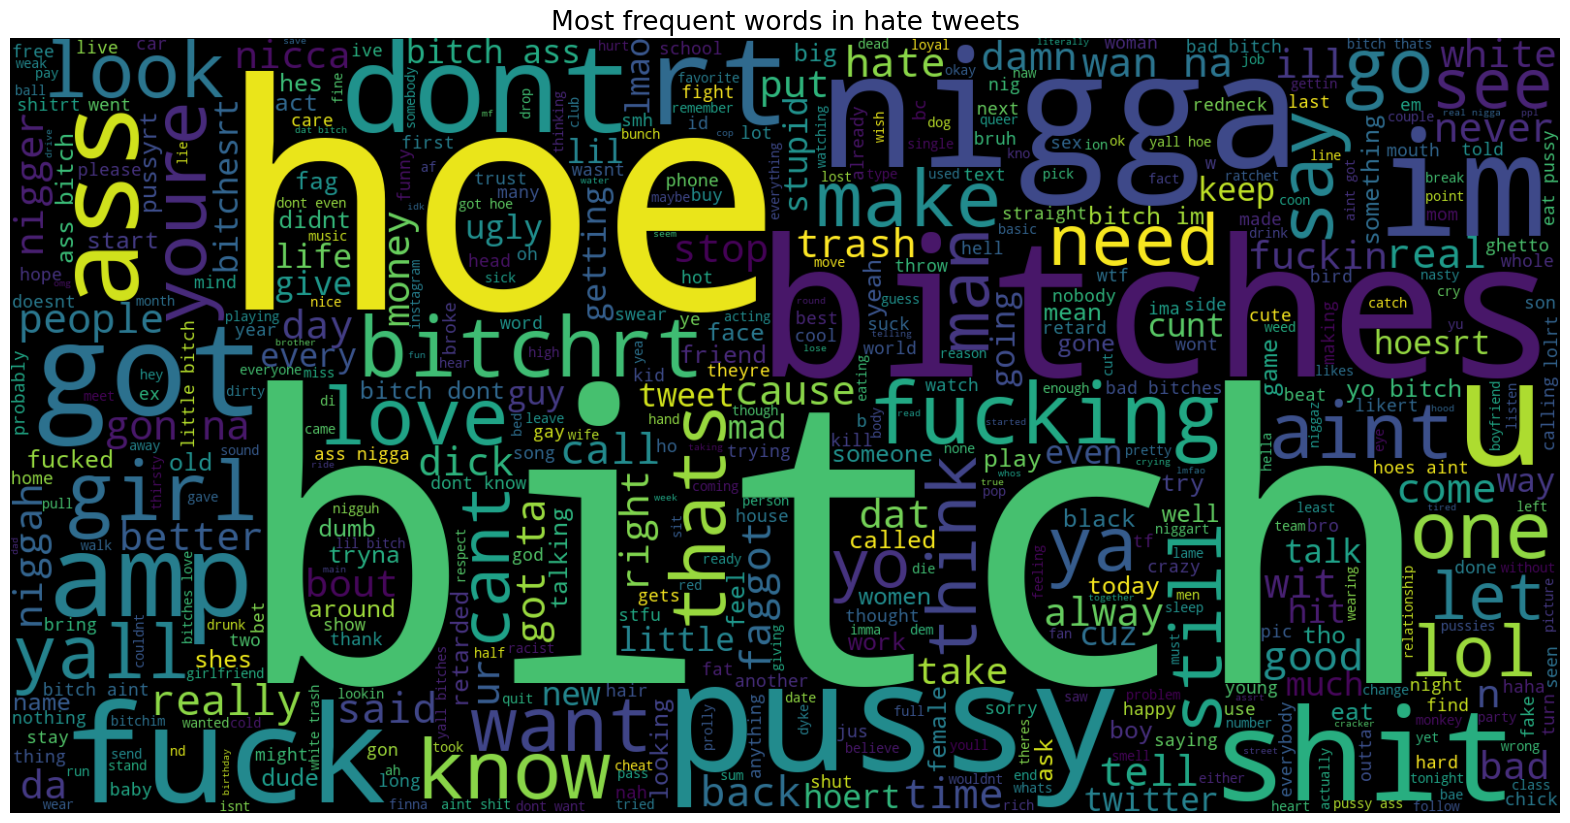

In [23]:
# visualizing non-hate tweets using word cloud
text=''.join([word for word in hate_tweets['tweet']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in hate tweets", fontsize=19)
plt.show()

In [24]:
texts = tweetData['tweet']
labels = tweetData['labels']

In [25]:
# Create a bag-of-words model
Count_vectorizer = CountVectorizer()
Count_features = Count_vectorizer.fit_transform(texts)
# texts = Count_vectorizer.transform(texts)

# Get the feature names
Count_feature_names = Count_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(Count_feature_names)}\n")
print("First 200 features: \n", format(Count_feature_names[:20]))

Number of features: 30134

First 200 features: 
 ['aa' 'aaaaaaaaand' 'aaahhhhh' 'aahahah' 'aaliyah' 'aaliyahhhm'
 'aaliyahhlovee' 'aamaadmiparty' 'aampt' 'aamu' 'aan' 'aanderlusting'
 'aap' 'aaron' 'aaroncarter' 'aaronkeplin' 'aaronmacgruder' 'aaronthegoat'
 'aaronworthing' 'aaryn']


In [26]:
# Create an bi-gram vectorizer
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_features = bigram_vectorizer.fit_transform(texts)

# Get the feature names
bigram_feature_names = bigram_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(bigram_feature_names)}\n")
print("First 200 features: \n", format(bigram_feature_names[:20]))

Number of features: 161774

First 200 features: 
 ['aa' 'aa classes' 'aa lol' 'aaaaaaaaand' 'aaaaaaaaand begins' 'aaahhhhh'
 'aaahhhhh internet' 'aahahah' 'aahahah fuck' 'aaliyah' 'aaliyah curving'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhlovee' 'aaliyahhlovee yu'
 'aamaadmiparty' 'aamaadmiparty mix' 'aampt' 'aampt ackin' 'aamu']


In [27]:
# Create a tri-gram vectorizer
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_features = trigram_vectorizer.fit_transform(texts)
final_texts = trigram_vectorizer.transform(texts)

# Get the feature names
trigram_feature_names = trigram_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(trigram_feature_names)}\n")
print("First 200 features: \n", format(trigram_feature_names[:20]))

Number of features: 310426

First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aa lol gduenez' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aaliyah curving' 'aaliyah curving low'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhhm knowww righttt']


In [28]:
# Create a TF-IDF vectorizer
Tfidf_vectorizer = TfidfVectorizer()
Tfidf_features = Tfidf_vectorizer.fit_transform(texts)

# Get the feature names
Tfidf_feature_names = Tfidf_vectorizer.get_feature_names_out()

# Print the top 20 features
print(f"Number of features: {len(Tfidf_feature_names)}\n")
print("First 200 features: \n", format(Tfidf_feature_names[:20]))

Number of features: 30134

First 200 features: 
 ['aa' 'aaaaaaaaand' 'aaahhhhh' 'aahahah' 'aaliyah' 'aaliyahhhm'
 'aaliyahhlovee' 'aamaadmiparty' 'aampt' 'aamu' 'aan' 'aanderlusting'
 'aap' 'aaron' 'aaroncarter' 'aaronkeplin' 'aaronmacgruder' 'aaronthegoat'
 'aaronworthing' 'aaryn']


In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(final_texts, labels, test_size=0.3, random_state=42)

In [30]:
#printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (17154, 310426)
Size of Y_train (17154,)
Size of X_test (7352, 310426)
Size of Y_test (7352,)


Accuracy: 0.9270946681175191
Precision: 0.9554616384915474
Recall: 0.957328990228013
F1 score: 0.9563944028636512
[[5878  262]
 [ 274  938]]


                       precision    recall  f1-score   support

          Hate Speech       0.96      0.96      0.96      6140
No Hate and Offensive       0.78      0.77      0.78      1212

             accuracy                           0.93      7352
            macro avg       0.87      0.87      0.87      7352
         weighted avg       0.93      0.93      0.93      7352



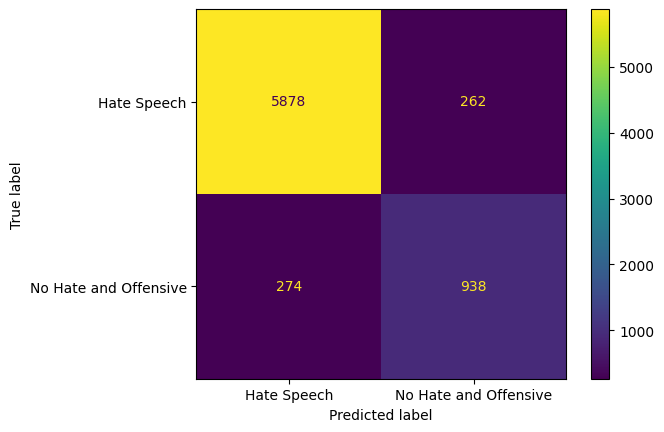

In [31]:
# Create a Naive Bayes classifier
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, Y_train)
NB_predictions = NB_classifier.predict(X_test)

# Evaluate the performance of the classifier
NB_accuracy = accuracy_score(Y_test, NB_predictions)
NB_precision = precision_score(Y_test, NB_predictions, pos_label="Hate Speech")
NB_recall = recall_score(Y_test, NB_predictions, pos_label="Hate Speech")
NB_f1 = f1_score(Y_test, NB_predictions, pos_label="Hate Speech")

# Print the evaluation metrics
print("Accuracy:", NB_accuracy)
print("Precision:", NB_precision)
print("Recall:", NB_recall)
print("F1 score:", NB_f1)

# Create a confusion matrix
NB_cm = confusion_matrix(Y_test, NB_predictions)

#printing confusion matrix and classification report
print(NB_cm)
print("\n")
print(classification_report(Y_test, NB_predictions))

#for visualizing confusion matrix
# style.use('classic')
disp = ConfusionMatrixDisplay(confusion_matrix=NB_cm, display_labels=NB_classifier.classes_)
disp.plot()

Accuracy: 0.9292709466811752
Precision: 0.9355238685678859
Recall: 0.9830618892508143
F1 score: 0.9587039390088945
[[6036  104]
 [ 416  796]]


                       precision    recall  f1-score   support

          Hate Speech       0.94      0.98      0.96      6140
No Hate and Offensive       0.88      0.66      0.75      1212

             accuracy                           0.93      7352
            macro avg       0.91      0.82      0.86      7352
         weighted avg       0.93      0.93      0.92      7352



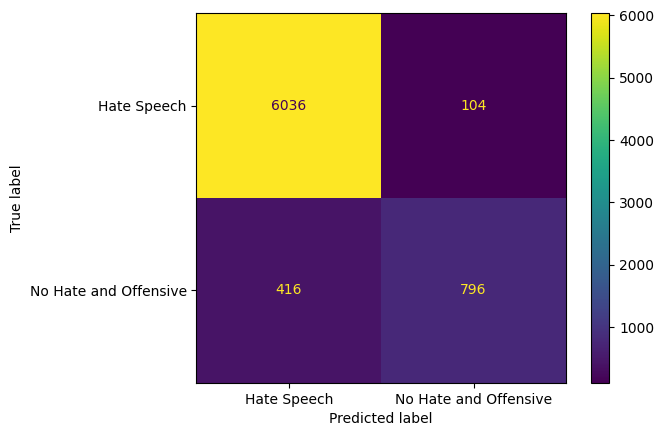

In [32]:
# Create an SVM classifier
SVM_classifier = SVC(probability=True)
SVM_classifier.fit(X_train, Y_train)
SVM_predictions = SVM_classifier.predict(X_test)

# Evaluate the performance of the classifier
SVM_accuracy = accuracy_score(Y_test, SVM_predictions)
SVM_precision = precision_score(Y_test, SVM_predictions, pos_label="Hate Speech")
SVM_recall = recall_score(Y_test, SVM_predictions, pos_label="Hate Speech")
SVM_f1 = f1_score(Y_test, SVM_predictions, pos_label="Hate Speech")

# Print the evaluation metrics
print("Accuracy:", SVM_accuracy)
print("Precision:", SVM_precision)
print("Recall:", SVM_recall)
print("F1 score:", SVM_f1)

# Create a confusion matrix
SVM_cm = confusion_matrix(Y_test, SVM_predictions)

#printing confusion matrix and classification report
print(SVM_cm)
print("\n")
print(classification_report(Y_test, SVM_predictions))

#for visualizing confusion matrix
# style.use('classic')
disp = ConfusionMatrixDisplay(confusion_matrix=SVM_cm, display_labels=SVM_classifier.classes_)
disp.plot()

In [33]:
Y_test = [1 if label == "No Hate and Offensive" else 0 for label in Y_test]
NB_pred_prob = NB_classifier.predict_proba(X_test)[:,1]
SVM_pred_prob = SVM_classifier.predict_proba(X_test)[:,1]

In [34]:
# Calculate ROC curve and AUC score
NB_fpr, NB_tpr, NB_thresholds = roc_curve(Y_test, NB_pred_prob)
SVM_fpr, SVM_tpr, SVM_thresholds = roc_curve(Y_test, SVM_pred_prob)
# print(fpr)
# print(tpr)
NB_auc = auc(NB_fpr, NB_tpr)
SVM_auc = auc(SVM_fpr, SVM_tpr)

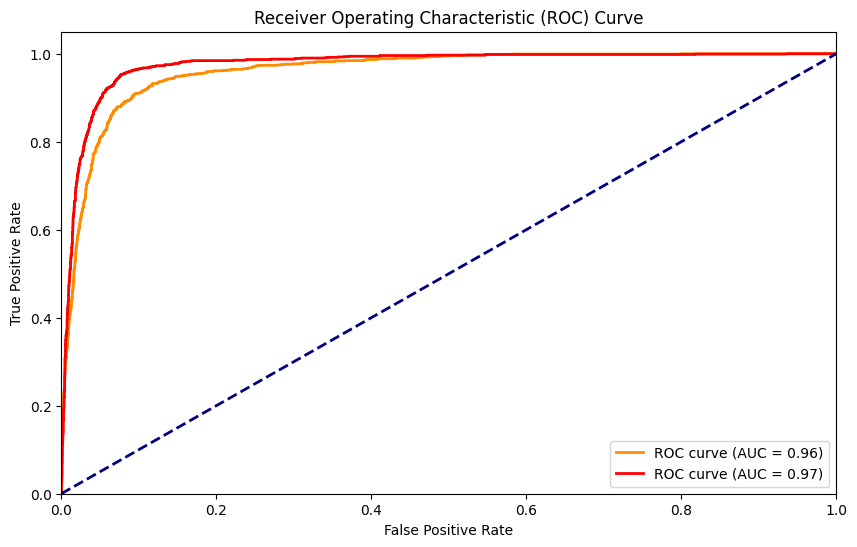

NB AUC score: 0.9601530837122798
SVM AUC score: 0.9748562824523496


In [36]:

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(NB_fpr, NB_tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {NB_auc:.2f})')
plt.plot(SVM_fpr, SVM_tpr, color='red', lw=2, label=f'ROC curve (AUC = {SVM_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print("NB AUC score:", NB_auc)
print("SVM AUC score:", SVM_auc)